In [1]:
begin
    using Pkg
    Pkg.activate("../")
    Pkg.instantiate()
end

include("../modules/DataIO.jl")
include("../modules/Model.jl")

using FASTX,
    Plots,
    DecisionTree,
    LinearAlgebra,
    .DataIO,
    .Model


  Activating project at `~/Desktop/rrm-genomic-extractor`


### Collectiong histogram as datasets

1. Define Hyperparams and data variables

In [2]:
wnwPercent::Float32 = 0.004
variantDirPath::String = "/home/salipe/Desktop/datasets/tutorial_data/kmers"

cachdir::String = "$(pwd())/.project_cache/$wnwPercent"

try
    mkpath(cachdir)
catch e
    @error "create cache direcotry failed" exception = (e, catch_backtrace())
end

"/home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004"

2. Load Kmers set

In [4]:
variantDirs::Vector{String} = readdir(variantDirPath)
kmerset = Set{String}()

@simd for variant in variantDirs
    variantKmers = DataIO.read_pickle_data("$variantDirPath/$variant/$(variant)_ExclusiveKmers.sav")
    union!(kmerset, Set(variantKmers))
end

kmerset

Set{String} with 4293 elements:
  "TAAAATCAGCACCTT"
  "GGAATTTCAAGAACT"
  "GTCTACTACAGTCAG"
  "GTGGTCTCCCTCAGG"
  "GAACCGACGATGACT"
  "GTTAGTGCTAAATCA"
  "ATGGCTGTGATGCTG"
  "CTTCTAGAGTTCTTG"
  "ATTACATTATAAACC"
  "GTTTTTTTATGTACT"
  "ATAACTTTTAAAGAA"
  "GCTATGCCTTCGAAT"
  "CATCTAGATGGTGAA"
  "CTTGTTTTAAGCTTT"
  "TTACCACAGAAATTT"
  "TAGAGTGTTAGGTTT"
  "GGTTGGGAACTTGTT"
  "GATAATAGGCTTAAA"
  "TACACACAACACATT"
  ⋮ 

3. Loading dataset informatio
    - Load sequences
    - Defining Kmer regex function and Window operation values

In [5]:
input_data = Vector{Tuple{String,Vector{Vector{Float64}}}}(undef, length(variantDirs))

@inbounds for v in eachindex(variantDirs)
    variant::String = variantDirs[v]
    cache_path = "$cachdir/$(variant)_wndfreqsignals.dat"

    cache::Union{Nothing,Vector{Vector{Float64}}} = DataIO.load_cache(cache_path)

    @info "Using cached data from $cache_path"
    input_data[v] = (variant, cache)


end

┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Alpha_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:9
┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Beta_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:9
┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Delta_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:9
┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Gamma_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e

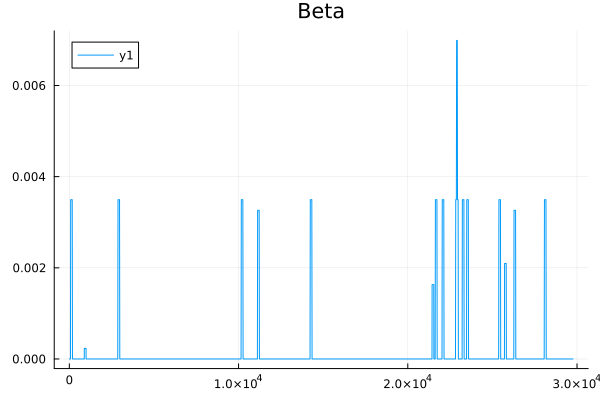

In [ ]:
# Alpha, Gamma, Beta, Omicron, Delta

class, signals = input_data[2]

plot(signals[15], title=class)

In [ ]:
minlen = minimum(x -> minimum(length, x[2]), input_data)
maxlen = maximum(x -> maximum(length, x[2]), input_data)

@show minlen, maxlen

(minlen, maxlen) = (29684, 29789)


(29684, 29789)

## Classification Tests

### Decision Tree

In [ ]:
X = Vector{Vector{Float64}}()
encode::Dict{String,Float16} = Dict(
    "Alpha" => 0,
    "Gamma" => 1,
    "Beta" => 2,
    "Delta" => 3,
    "Omicron" => 4,
)
labels = Vector{Float16}()

for (class, signals) in input_data
    for signal in signals
        push!(X, signal[1:minlen])
        push!(labels, encode[class])
    end
end



### Multinomial Naive Bayes Implementation

1. Defining Model Structure

In [6]:
struct MultinomialNaiveBayes
    classes::Vector{Any}
    priors::Dict{Any, Float64}       # Class priors (log probabilities)
    feature_log_probs::Dict{Any, Vector{Float64}}  # Log probabilities of features per class
end

2. Implementing Training Function

In [7]:
function fit_multinomial_nb(
    X::Matrix{Int64},  # Input must be integer counts
    y::Vector;
    alpha::Float64 = 1.0  # Laplace smoothing parameter
)
    classes = unique(y)
    n_samples, n_features = size(X)
    priors = Dict{eltype(y), Float64}()
    feature_log_probs = Dict{eltype(y), Vector{Float64}}()

    for c in classes
        # Get samples of the current class
        mask = y .== c
        X_class = X[mask, :]
        n_class = size(X_class, 1)

        # Calculate class prior (log probability)
        priors[c] = log(n_class / n_samples)

        # Compute smoothed counts for each feature
        # Add alpha to avoid zero probabilities (Laplace smoothing)
        count = vec(sum(X_class, dims=1)) .+ alpha
        total_count = sum(count)
        
        # Compute log probabilities (normalize counts to probabilities and take log)
        log_probs = log.(count ./ (total_count + alpha * n_features))
        feature_log_probs[c] = log_probs
    end

    MultinomialNaiveBayes(classes, priors, feature_log_probs)
end

fit_multinomial_nb (generic function with 1 method)

3. Prediction Function

In [11]:
function predict(model::MultinomialNaiveBayes, X::Matrix{Int64})
    n_samples = size(X, 1)
    predictions = Vector{eltype(model.classes)}(undef, n_samples)

    for i in 1:n_samples
        x = X[i, :]
        max_log_prob = -Inf
        best_class = model.classes[1]

        for c in model.classes
            # Log prior for the class
            log_prior = model.priors[c]
            
            # Log likelihood: sum (x_j * log(feature_prob_j))
            log_likelihood = dot(x, model.feature_log_probs[c])
            
            # Total log probability
            total_log_prob = log_prior + log_likelihood

            if total_log_prob > max_log_prob
                max_log_prob = total_log_prob
                best_class = c
            end
        end

        predictions[i] = best_class
    end

    predictions
end

predict (generic function with 1 method)

### Testing Classification

In [ ]:
# Example: Text classification (word counts)
# 3 samples, 4 features (word counts), 2 classes
X = [
    1 2 0 1;  # Class 0
    0 1 3 2;  # Class 0
    2 0 1 1;   # Class 1
]
y = [0, 0, 1]

# Train the model
model = fit_multinomial_nb(X, y, alpha=1.0)

# Predict a new sample (e.g., word counts [2, 1, 0, 0])
new_sample = [2 1 0 0]
predicted_class = predict(model, new_sample)

1-element Vector{Any}:
 0

In [8]:
rndForest = RandomForestRegressor()

X_matrix = reduce(hcat, X) |> permutedims

# Ensure y is a row vector with correct dimensions (1 x n_samples)
DecisionTree.fit!(rndForest, X_matrix, labels)

RandomForestRegressor
n_trees:             10
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    5
min_samples_split:   2
min_purity_increase: 0.0
ensemble:            Ensemble of Decision Trees
Trees:      10
Avg Leaves: 11.0
Avg Depth:  5.3

In [14]:

classeqs = Vector{String}()

wnwSize::UInt16 = ceil(UInt16, minlen * wnwPercent)

for v in eachindex(variantDirs)
    class = variantDirs[v]
    for record in open(FASTAReader, "/home/salipe/Desktop/datasets/test_voc/test/$class.fasta")
        seq::String = sequence(String, record)
        push!(classeqs, seq)
        break
    end
end

data = Model.wndwSequencesKmersHistogram(kmerset, wnwSize, classeqs)




5-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

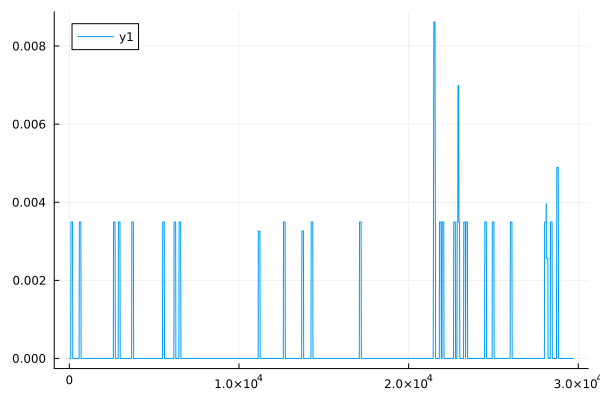

In [23]:
plot(data[4])

In [20]:
input = reduce(hcat, data) |> permutedims
raw_output = predict(rndForest, input)

raw_output

5-element Vector{Float16}:
 0.0
 1.967
 3.0
 1.0
 4.0